In [1]:
### This noteboook is used for dealing with problem in ContiguousSNP
import sys
import os
import zipfile
from scipy import stats

## import function from python_scripts
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from python_scripts.gene_level_MoM import * 
from python_scripts.pairwise_product_var_calculation import * 
from python_scripts.visualization import * 
from python_scripts.weight_function import * 

In [3]:
###unzip file
zip_files = [
    "../test_data/chr1_Contiguous1KSNP.zip",
    "../test_data/chr1_Random1KSNP.zip"
]
for zf in zip_files:
    with zipfile.ZipFile(zf, "r") as z:
        z.extractall("test_data")   
    print(f"Unzipped: {zf}")
##read data  
##Random snp
RandomSNP = pd.read_csv("test_data/chr1_Random1KSNP.raw", sep=r'\s+')
RandomSNP = RandomSNP.iloc[:, 6:].to_numpy()
##Contiguous snp
ContiguousSNP = pd.read_csv("test_data/chr1_Contiguous1KSNP.raw", sep=r'\s+')
ContiguousSNP = ContiguousSNP.iloc[:, 6:].to_numpy()

Unzipped: ../test_data/chr1_Contiguous1KSNP.zip
Unzipped: ../test_data/chr1_Random1KSNP.zip


#### **Experiment 1**: Use Allel frequency of ith and jth SNP $(p_i, p_j)$ and their covariance $\sigma_{ij}$  to represent pairwise product variance (Var$ Z_i Z_j$). We will use two simulated SNPs and compare their emprical variance and variance calculatged by formula to validate.

In [5]:
# set parameter
n = 2
p1 = 0.3
p2 = 0.4
sigmaij = 0.2
c = sigmaij / n  
p11 = p1 * p2 + c
p10 = p1 - p11
p01 = p2 - p11
p00 = 1 - p11 - p10 - p01

sizes = [1000,10000,100000,1000000,10000000]

for size in sizes:
     ### simulate two SNPs
     probs = np.array([p00, p01, p10, p11])
     codes = np.random.choice(4, size=(size, n), p=probs)
     
     X1 = ((codes == 2) | (codes == 3)).sum(axis=1)
     X2 = ((codes == 1) | (codes == 3)).sum(axis=1)
     X = np.column_stack((X1, X2))
     Z = (X - X.mean(axis=0)) / X.std(axis=0)
     var_zizj_formule= calculate_varZiZj(X)[0]
     empirical_var_zizj= np.var(Z[:,0]*Z[:,1])

     ### compare their result
     print(" ")
     print(f"Under the size of individual:{size}")
     print(f"The var(zizj) given by formule:{var_zizj_formule}")
     print(f"The empirical var(zizj):{empirical_var_zizj}")
     print(f"The relative error:{(var_zizj_formule - empirical_var_zizj) / empirical_var_zizj:.6f}")

 
Under the size of individual:1000
The var(zizj) given by formule:1.0821074793449237
The empirical var(zizj):1.1048484435728123
The relative error:-0.020583
 
Under the size of individual:10000
The var(zizj) given by formule:1.0747274883315807
The empirical var(zizj):1.0840534174604655
The relative error:-0.008603
 
Under the size of individual:100000
The var(zizj) given by formule:1.0780904088916243
The empirical var(zizj):1.0781280383308671
The relative error:-0.000035
 
Under the size of individual:1000000
The var(zizj) given by formule:1.07853249628018
The empirical var(zizj):1.0774532197749014
The relative error:0.001002
 
Under the size of individual:10000000
The var(zizj) given by formule:1.0795297072917682
The empirical var(zizj):1.0795318489713448
The relative error:-0.000002


#### **Experiment 1 Summary**: As sample size increases, the formula-based variance converges to the empirical variance, with relative error dropping to ~0.01% at 10M individuals. This validates the correctness of the closed-form expression for Var$(Z_i Z_j)$

#### **Experiment 2**: Investigate why the MoM estimator produces biased results with contiguous SNPs compared to random SNPs, by ploting the overall distribution of pairwise product variance Var$(Z_i Z_j)$.

------------------RandomSNP distribution-------------------


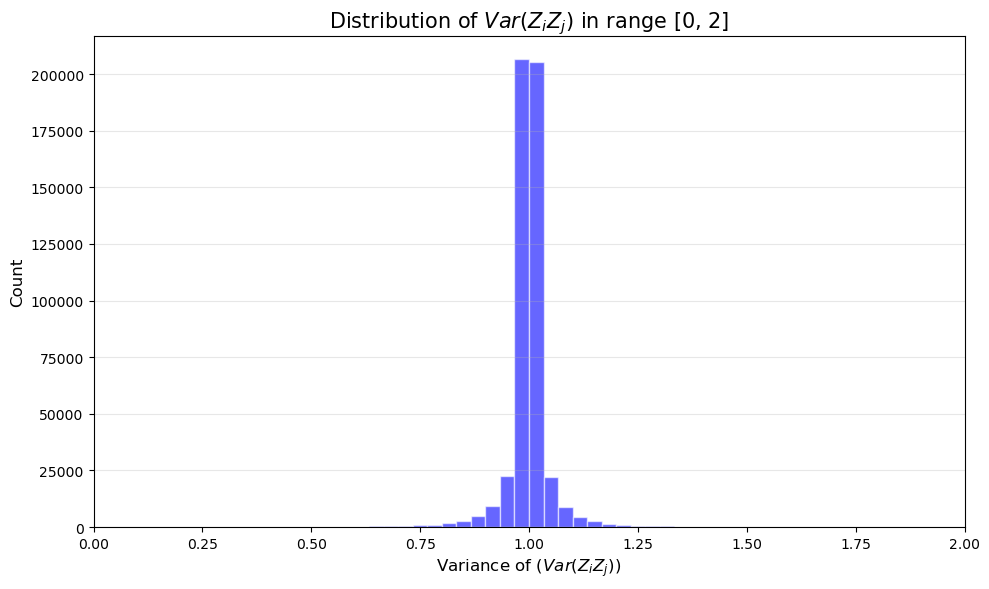

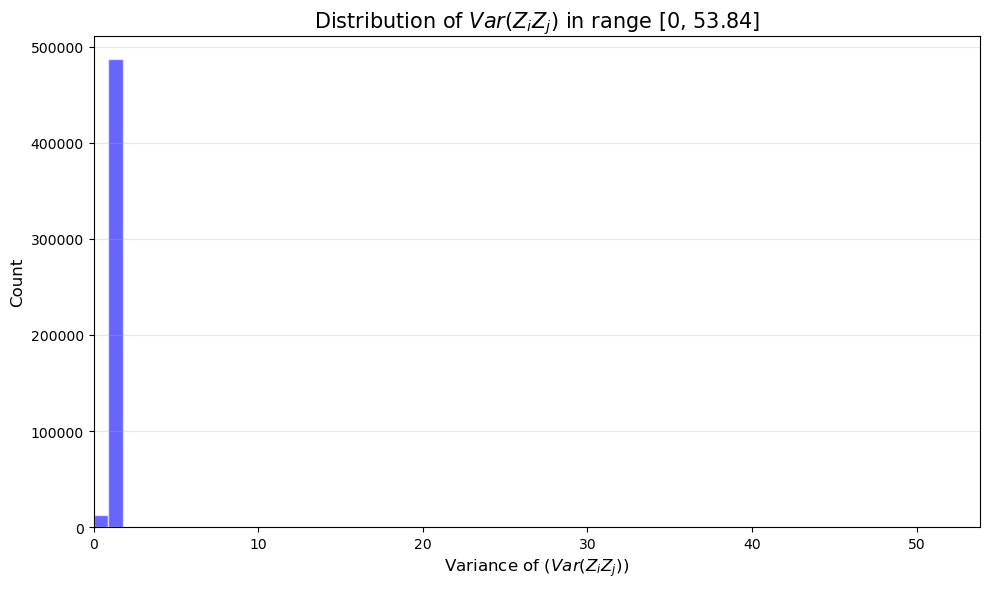

------------------ContiguousSNP distribution-------------------


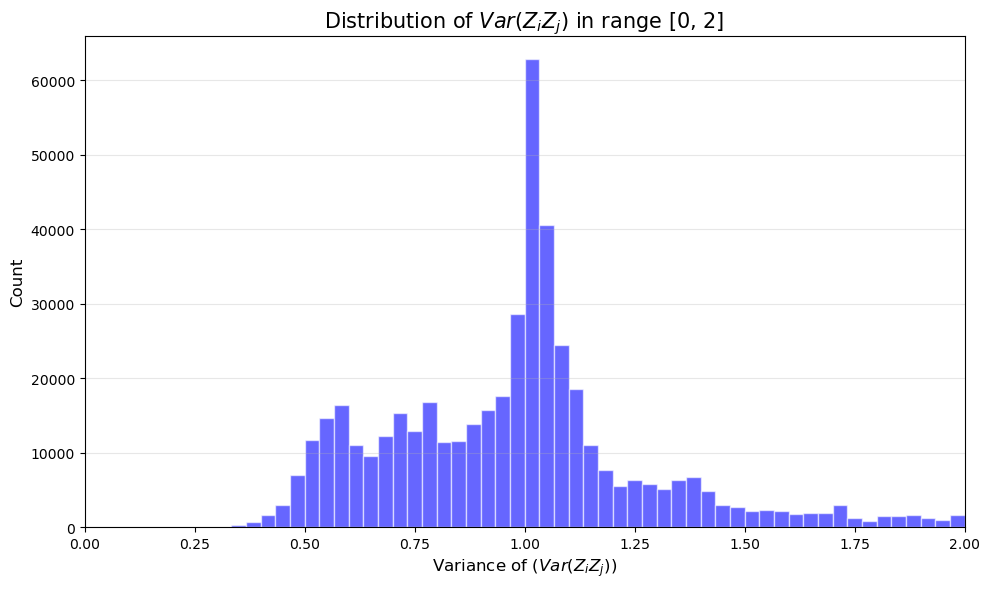

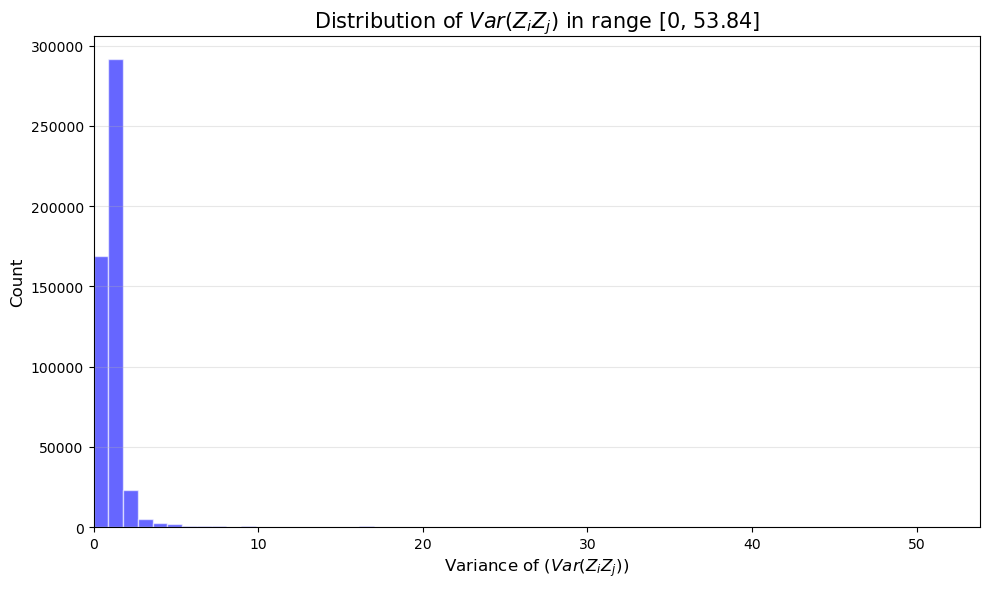

In [6]:
RandomSNP_varZiZj= calculate_varZiZj(RandomSNP)
ContiguousSNP_varZiZj= calculate_varZiZj(ContiguousSNP)

RandomSNP_varXiXj= calculate_varXiXj(RandomSNP)
ContiguousSNP_varXiXj= calculate_varXiXj(ContiguousSNP)

### draw the distribution
print("------------------RandomSNP distribution-------------------")
plot_distribution_varzizj(RandomSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(RandomSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60)  ## draw the distriburion of all variance  
print("------------------ContiguousSNP distribution-------------------")
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60) ## draw the distriburion of all variance

#### **Experiment 2 Summary**: Contiguous SNPs exhibit heavier tails with more extreme variance values compared to random SNPs, and the distribution is skewed.

#### **Experiment 3**: Investigate why the MoM estimator produces biased results with contiguous SNPs compared to random SNPs, by examining the distribution of pairwise product variance Var$(Z_i Z_j)$ and the LD ($r_{ij}$).

------------------RandomSNP case-------------------


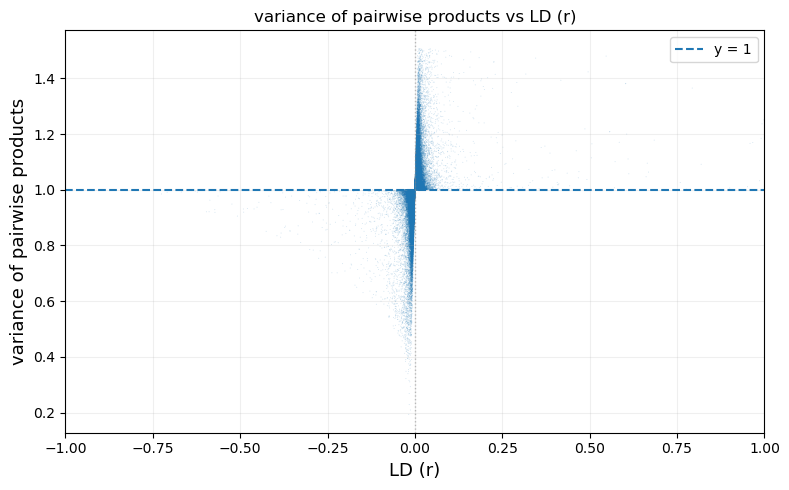

------------------ContiguousSNP case-------------------


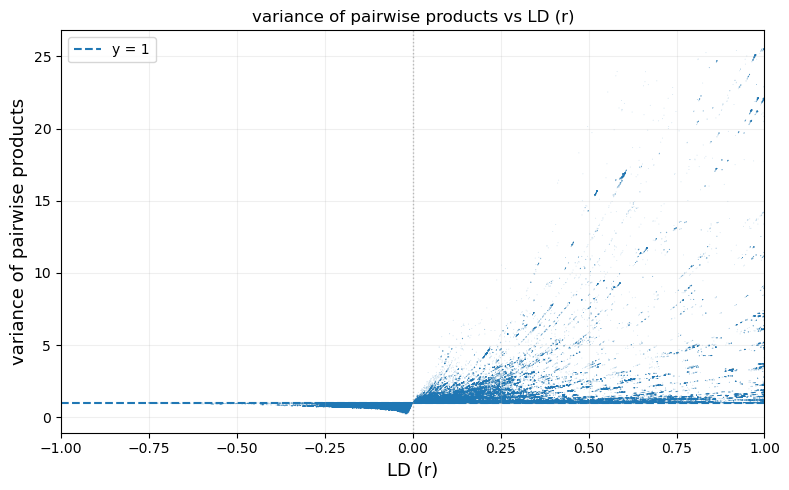

In [7]:
### experiment3: check the distibution of pairwise product variance (var zizj) against with LD (r)
def ld_vector(X):
    corr_matrix = np.corrcoef(X, rowvar=False)
    iu = np.triu_indices(X.shape[1], k=1)
    return corr_matrix[iu]


print("------------------RandomSNP case-------------------")
ld_RandomSNP =  ld_vector(RandomSNP)
plot_var_pairwise_products_against_ld(RandomSNP_varZiZj, ld_RandomSNP, q=0.999, save_path=None)


print("------------------ContiguousSNP case-------------------")
ld_ContiguousSNP =  ld_vector(ContiguousSNP)
plot_var_pairwise_products_against_ld(ContiguousSNP_varZiZj, ld_ContiguousSNP, q=0.999, save_path=None)

#### **Experiment 3 Summary**: High LD (particularly positive correlation) between Contiguous SNPs is the main factor behind inflated Var$(Z_i Z_j)$, which in turn biases the MoM estimator.

#### **Experiment 4**:

We investigate three factors that may affect gxg heritability ($h^2_{g \times g}$) estimation: linkage disequilibrium (LD), minor allele frequency (MAF), and number of SNPs. We categorize our test data into 12 groups using the following criteria:

**LD levels (3 bins):**
- High LD: SNPs pruned at $r^2 > 0.9$
- Medium LD: SNPs pruned at $r^2 > 0.5$
- Low LD: SNPs pruned at $r^2 > 0.2$

**MAF thresholds (2 bins):**
- All variants: no MAF filtering
- Common variants: MAF ≥ 0.05

**SNP number (2 bins):**
- Small dataset: 600 SNPs
- Large dataset: 1800 SNPs

We examine how these factors influence estimation bias and standard error of $\hat h^2_{g \times g}$.

In [3]:
### Read all data
individual_sizes = [1000,2000,4000,8000]
##high-LD group
highLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","highLD_largeDataset_allVariants",1800)
highLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","highLD_largeDataset_commonVariants",1800)
highLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","highLD_smallDataset_allVariants",600)
highLD_smallDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","highLD_smallDataset_commonVariants",600)

##middle-LD group
middleLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","middleLD_largeDataset_allVariants",1800)
middleLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","middleLD_largeDataset_commonVariants",1800)
middleLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","middleLD_smallDataset_allVariants",600)
middleLD_smallDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","middleLD_smallDataset_commonVariants",600)

##low-LD group
lowLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","lowLD_largeDataset_allVariants",1800)
lowLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","lowLD_largeDataset_commonVariants",1800)
lowLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","lowLD_smallDataset_allVariants",600)
lowLD_smallDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","lowLD_smallDataset_commonVariants",600)


##independent SNP group
independent_m125 = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","independent",125)
independent_m250 = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","independent",250)
independent_m500 = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","independent",500)
independent_m1000 = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","independent",1000)
independent_m2000 = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","independent",2000)


## standardlization group
highLD_largeDataset_allVariants_standard = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","highLD_large_all_standard_MOM",1800)

## corrected group
individual_sizes = [1000,2000,4000]
highLD_largeDataset_allVariants_corrected = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","Corrected_highLD_large_all",1800)


### the previsoue code
#individual_sizes = [1000,2000,4000,8000]
#highLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/highLD_largeDataset_allVariants/",1800)
#HLA = [highLD_largeDataset_allVariants[n] for n in individual_sizes]

#print("------------------Figure4.1 High LD_Large dataset_All variants case-------------------")
#plot_relative_error_accross_sample_size(
#    *HLA, 
#    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
#)


#### **Experiment 4.1**:
We investigate whether the level of LD influences 
the bias of the epistatic heritability estimator $\hat{h}^2_{g \times g}$.

**Hypothesis**:  The level of LD positively influences the bias of the 
epistatic heritability estimator $\hat{h}^2_{g \times g}$. Specifically, 
higher LD levels lead to greater bias in the estimator.


**Simple Inference**: We derive a closed-form expression for the variance of the pairwise 
product of two standardized SNPs $Z_i$ and $Z_j$ in terms of their 
allele frequencies $(p_i, p_j)$ and their correlation $r_{ij}$:

$$
\text{Var}(Z_i Z_j) = 1 + \frac{r_{ij}(1 - 2p_i)(1 - 2p_j)}{4\sqrt{p_i p_j (1 - p_i)(1 - p_j)}}
$$


When two SNPs are independent($r^2 =0, \sigma_{ij} = 0$),  their pairwise product has unit variance $\text{Var}(Z_i Z_j) = 1$. Extending this to a full dataset, if all SNPs in a standardized genotype matrix are mutually independent, then all pairwise products will have unit variance.

When LD is present, 
even after standardizing the genotype matrix, the pairwise product 
variance deviates from one:

$$
\underbrace{\frac{r_{ij}(1 - 2p_i)(1 - 2p_j)}{4\sqrt{p_i p_j (1 - p_i)(1 - p_j)}}}_{\text{LD-induced distortion}}
$$

The direction of influence depends jointly on the sign of $r_{ij}$ 
and the allele frequencies.

Since the epistatic 
kernel $K_{g \times g}$ aggregates all pairwise products, LD-induced 
inflation or deflation of individual pairwise product variances 
propagates into the kernel. This means that different SNP pairs 
contribute unequally to $K_{g \times g}$, violating the equal 
contribution assumption underlying unbiased REML estimation of 
$\sigma^2_{g \times g}$.


**Experiment**

We compared three datasets with different LD levels across varying 
sample sizes to examine the influence of LD on estimation bias: 
`highLD_large_all`, `middleLD_large_all`, and `lowLD_large_all`. 
These datasets differ only in the LD pruning threshold, ensuring 
that any observed difference in estimator bias is attributable 
solely to the level of LD.

**Simulation Setup**

For each LD level and each sample size $N \in \{1000, 2000, 4000, 8000\}$,
we simulated phenotypic data and estimated the epistatic variance 
component $\hat{\sigma}^2_{g \times g}$ using our MOM method. The signed 
relative error was computed for each replicate as:

$$
\text{Relative Error} = \frac{\hat{\sigma}^2_{g \times g} - \sigma^2_{g \times g}}{\sigma^2_{g \times g}}
$$

**Statistical Test**

We regressed the signed relative error on the LD level:

$$
\frac{\hat{\sigma}^2_{g \times g} - \sigma^2_{g \times g}}{\sigma^2_{g \times g}}
= \beta_1 \cdot \text{LD} + \varepsilon
$$

where the intercept is constrained to zero ($\beta_0 = 0$), 
reflecting the theoretical result that the estimator is unbiased 
when SNPs are mutually independent (i.e., under zero LD). The 
hypothesis of interest is:

$$
H_0: \beta_1 = 0 \qquad  \qquad H_1: \beta_1 \neq 0
$$

**Decision:** If $\hat{\beta}_1$ is statistically significant 
(i.e., the null hypothesis $H_0: \beta_1 = 0$ is rejected at the 
$\alpha = 0.05$ level), we conclude that LD significantly biases 
the estimator $\hat{\sigma}^2_{g \times g}$.
Conversely, if $\hat{\beta}_1$ is not significant, we conclude 
that LD does not significantly affect the estimator, and no 
correction is necessary.

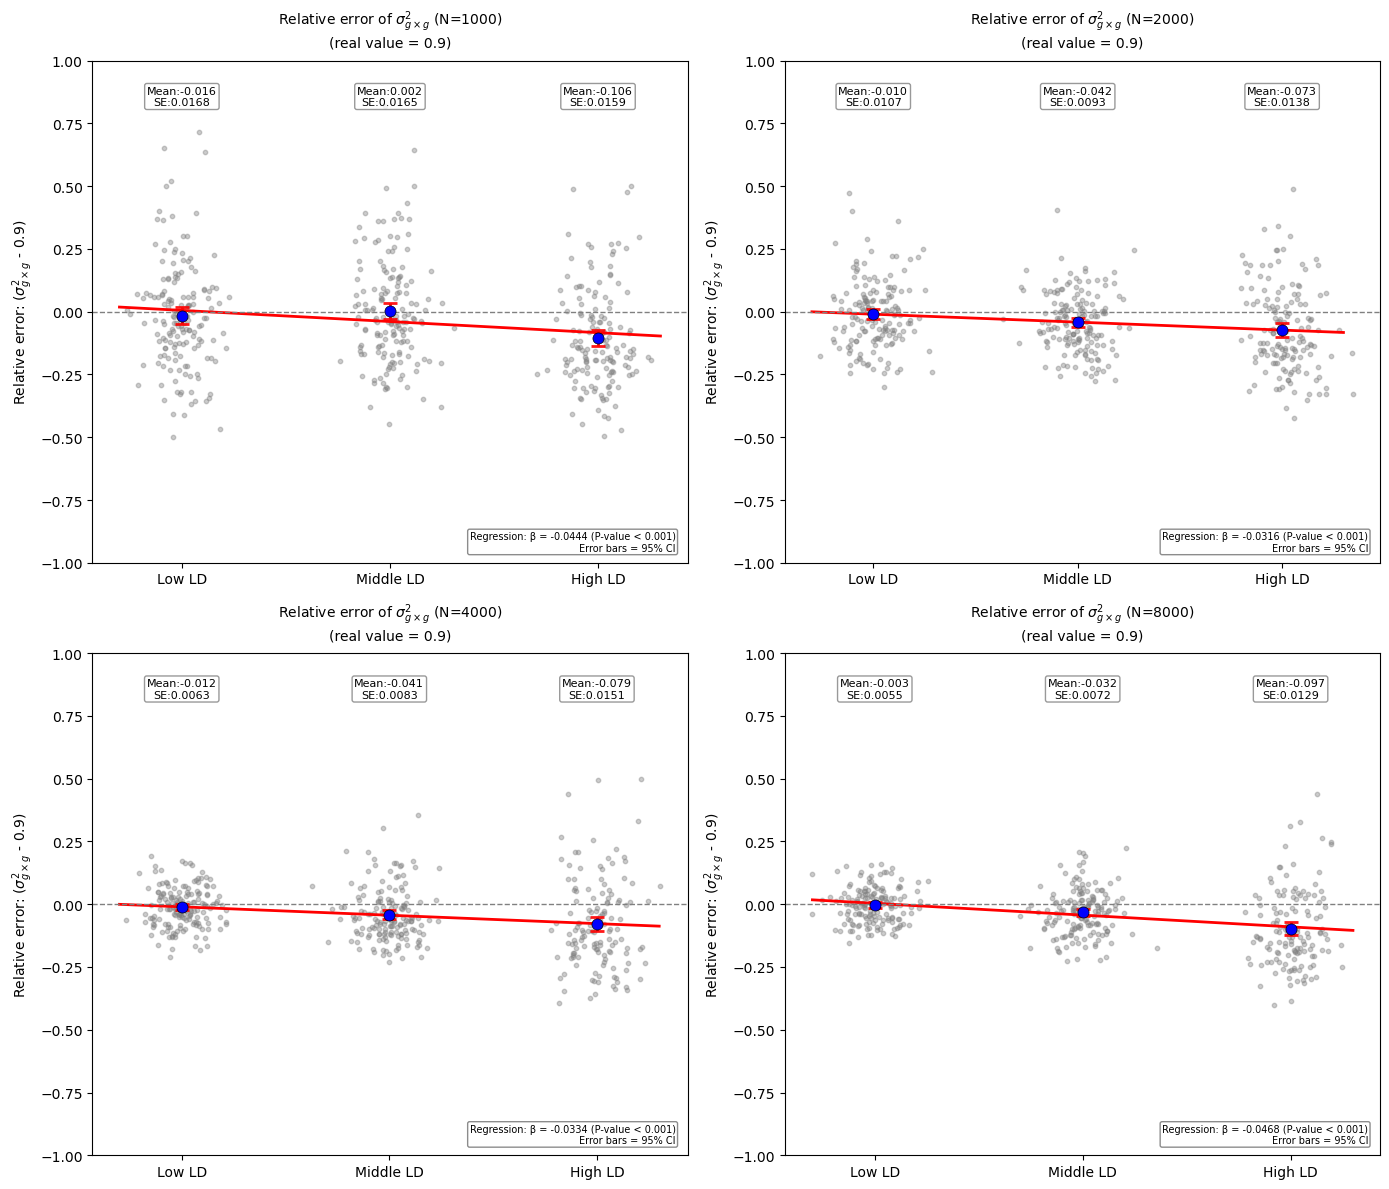

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

individual_sizes = [1000, 2000, 4000, 8000]
object_labels = ['Low LD', 'Middle LD', 'High LD'] 
for idx, n in enumerate(individual_sizes):
    data_dicts_by_object = {
        'Low LD': lowLD_largeDataset_allVariants[n],
        'Middle LD': middleLD_largeDataset_allVariants[n],
        'High LD': highLD_largeDataset_allVariants[n]
    }
    
    plot_relative_error_across_object(
        data_dicts_by_object=data_dicts_by_object,
        object_labels = object_labels,
        individual_size=n,
        col_num=0,
        real_value=0.9,
        ymin=-1.0,
        ymax=1.0,
        ax=axes[idx]
    )

plt.tight_layout()
plt.show()

#### **Experiment 4.1 Summary**

**Conclusion 1: LD significantly biases the estimator.** Across all 
four sample sizes, the regression slope $\hat{\beta}_1$ is 
significantly not equal to zero ($p < 0.001$), so we reject the 
null hypothesis $H_0: \beta_1 = 0$. We therefore conclude that 
LD significantly biases the epistatic heritability estimator 
$\hat{\sigma}^2_{g \times g}$.

**Conclusion 2: The bias is negative (underestimation).** The 
direction of $\hat{\beta}_1 < 0$ reveals that higher LD 
consistently leads to **underestimation** of the true epistatic 
variance component. Specifically, at Low LD the mean relative 
error is near zero (ranging from $-0.003$ to $-0.016$ across 
sample sizes), while at High LD it becomes substantially negative 
(ranging from $-0.073$ to $-0.106$). 

**Conclusion 3: The bias is robust to sample size.** The magnitude 
of $\hat{\beta}_1$ is consistent across all four sample sizes, 
ranging from $-0.032$ to $-0.047$. This suggests that the 
LD-induced bias is a structural property of the estimator 
rather than a finite-sample artifact, and persists even as 
$N$ increases.

#### **Experiment 4.3**:
## SNP Effect on Estimator Efficiency

We investigate whether the number of SNPs influences the efficiency rather than the bias of the epistatic heritability estimator $\hat{h}^2_{g \times g}$.

**Hypothesis**: The number of SNPs does not influence the bias but positively influences the efficiency of the epistatic heritability estimator $\hat{h}^2_{g \times g}$. Specifically, a greater number of SNPs leads to lower variance (higher efficiency) in the estimator, while the expected value remains unbiased.



**Simple Inference**: Under standard asymptotic theory for variance component estimation, the variance of MOM estimator decreases with increasing information in the data. For epistatic variance estimation, the effective information is determined by the number of independent SNP pairs contributing to the epistatic kernel $K_{g \times g}$.

For $M$ SNPs, the number of unique pairwise interactions is:

$$
\binom{M}{2} = \frac{M(M-1)}{2}
$$

The variance of the estimator $\hat{\sigma}^2_{g \times g}$ is approximately inversely proportional to the effective number of independent pairwise contributions:

$$
\text{Var}(\hat{\sigma}^2_{g \times g}) \propto \frac{1}{M_{\text{eff}}}
$$

where $M_{\text{eff}}$ represents the effective number of independent SNP pairs after accounting for LD. As the number of SNPs increases, $M_{\text{eff}}$ increases, leading to reduced estimator variance.

The expected value of the estimator remains unaffected by the number of SNPs:

$$
\mathbb{E}[\hat{\sigma}^2_{g \times g}] = \sigma^2_{g \times g}
$$

### Experiment

We compared six datasets with different numbers of SNPs across varying sample sizes with different LD levels to examine the influence of SNP count on estimation bias and efficiency: `highLD_large_all` vs `highLD_small_all` (highLD group),`middleLD_large_all` vs `middleLD_small_all` (middleLD group),`lowLD_large_all` vs `lowLD_small_all` (lowLD group). These datasets differ only in the number of SNPs included, ensuring that any observed difference in estimator properties is attributable solely to the SNP count.



### Simulation Setup

For each SNP level and each sample size $N \in \{1000, 2000, 4000, 8000\}$, we simulated phenotypic data and estimated the epistatic variance component $\hat{\sigma}^2_{g \times g}$ using our MOM method.

### Statistical Tests

We conduct two separate tests:

#### Test 1: Effect on Bias

We regressed the signed relative error on the number of SNPs:

$$
\frac{\hat{\sigma}^2_{g \times g} - \sigma^2_{g \times g}}{\sigma^2_{g \times g}} = \beta_0 + \beta_1 (M) + \varepsilon
$$

The hypothesis of interest is:

$$
H_0: \beta_1 = 0 \quad \text{(SNP count does not affect bias)}
$$

$$
H_1: \beta_1 \neq 0 \quad \text{(SNP count affects bias)}
$$

#### Test 2: Effect on Efficiency

We compare the variance of estimates between the two SNP groups using an F-test:

$$
F = \frac{\text{Var}(\hat{\sigma}^2_{g \times g} | M_{\text{small}})}{\text{Var}(\hat{\sigma}^2_{g \times g} | M_{\text{large}})}
$$

The hypothesis of interest is:

$$
H_0: \sigma^2_{\text{small}} \leq \sigma^2_{\text{large}} \quad \text{(No efficiency improvement)}
$$

$$
H_1: \sigma^2_{\text{small}} > \sigma^2_{\text{large}} \quad \text{(Efficiency improves with more SNPs)}
$$

Under $H_0$, the test statistic follows an F-distribution with $(n_1 - 1, n_2 - 1)$ degrees of freedom.

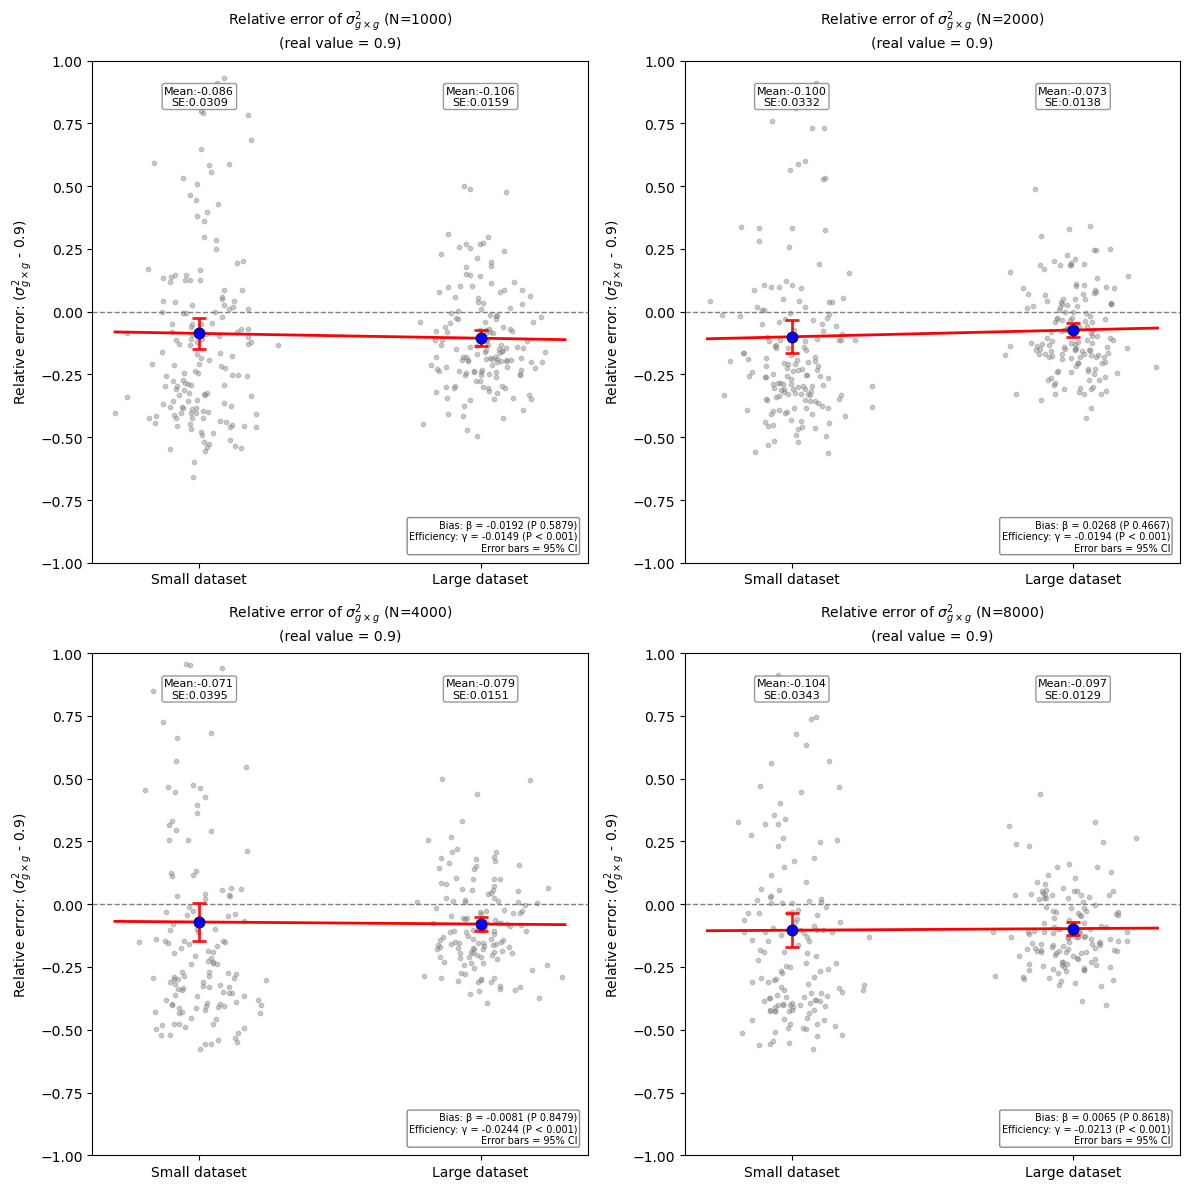

In [6]:
## highLD group
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

individual_sizes = [1000, 2000, 4000, 8000]
object_labels = ["Small dataset","Large dataset"]
for idx, n in enumerate(individual_sizes):
    data_dicts_by_object = {
        'Small dataset': highLD_smallDataset_allVariants[n],
        'Large dataset': highLD_largeDataset_allVariants[n],
    }
    
    plot_relative_error_across_object_withSE(
        data_dicts_by_object=data_dicts_by_object,
        object_labels = object_labels,
        individual_size=n,
        col_num=0,
        real_value=0.9,
        ymin=-1.0,
        ymax=1.0,
        ax=axes[idx]
    )
plt.tight_layout()
plt.show()
## middleLD group




#### **Experiment 4.3 Summary**:
1. Biasness: The #SNP has negligible influence in biasness, with infinite replicates, the bias of large dataset should equal to small dataset 

2. Efficicy: The method shows faster convergence for large datasets. Under the same sample size, large datasets groups have lower standard errors, which aligns with our expectations. Additionally, the benefit of larger datasets is more pronounced when LD levels are lower.

#### **Conclusion**:
#SNP affects efficiency but not bias. While larger datasets provide lower standard errors and faster convergence, particularly under low LD , the expected heritability estimate remains unbiased regardless of SNP number.


##  Summary table (Fixed N)

## Relative Error of Heritability Estimates Across LD Levels, MAF, and Sample Sizes

*Values shown as Mean (SD) of relative error; true $\sigma^2_{g \times g} = 0.9$*

| LD level | MAF | #SNP | N = 1K | N = 2K | N = 4K | N = 8K |
|:--------:|:---:|:----:|:------:|:------:|:------:|:------:|
| $r^2<0.9$ | all | 1800 | -0.106(0.195) | -0.073(0.168) | -0.079(0.177) | -0.097(0.151) |
|  |  | 600 | -0.086(0.390) | -0.100(0.420) | -0.071(0.462) | -0.104(0.413) |
|  | only common | 1800 | -0.178(0.141) | -0.149(0.107) | -0.167(0.086) | -0.165(0.077) |
|  |  | 600 | -0.239(0.174) | -0.241(0.144) | -0.225(0.159) | -0.247(0.148) |
| $r^2<0.5$ | all | 1800 | 0.002(0.209) | -0.042(0.117) | -0.041(0.105) | -0.032(0.091) |
|  |  | 600 | -0.035(0.190) | -0.027(0.187) | -0.060(0.154) | -0.065(0.154) |
|  | only common | 1800 | -0.058(0.195) | -0.057(0.122) | -0.066(0.080) | -0.050(0.066) |
|  |  | 600 | -0.107(0.169) | -0.105(0.117) | -0.103(0.093) | -0.102(0.083) |
| $r^2<0.2$ | all | 1800 | -0.016(0.213) | -0.010(0.135) | -0.012(0.080) | -0.003(0.070) |
|  |  | 600 | -0.031(0.182) | -0.019(0.133) | -0.018(0.106) | -0.021(0.094) |
|  | only common | 1800 | 0.041(0.340) | -0.044(0.205) | -0.023(0.097) | -0.009(0.064) |
|  |  | 600 | -0.021(0.187) | -0.050(0.114) | -0.040(0.077) | -0.028(0.065) |


#### **Experiment 4.31**:
We then invetigate the influence of number independent SNP. this is the extention of 4.3

**Hypothesis**: Number of independent SNP will influence the efficiency, More independent SNPs generally improve estimation efficiency .

Test: To examine the influence of the number of independent SNPs on estimation efficiency, we compared five datasets with extremely low LD (approximately independent SNPs) varying in the number of SNPs.

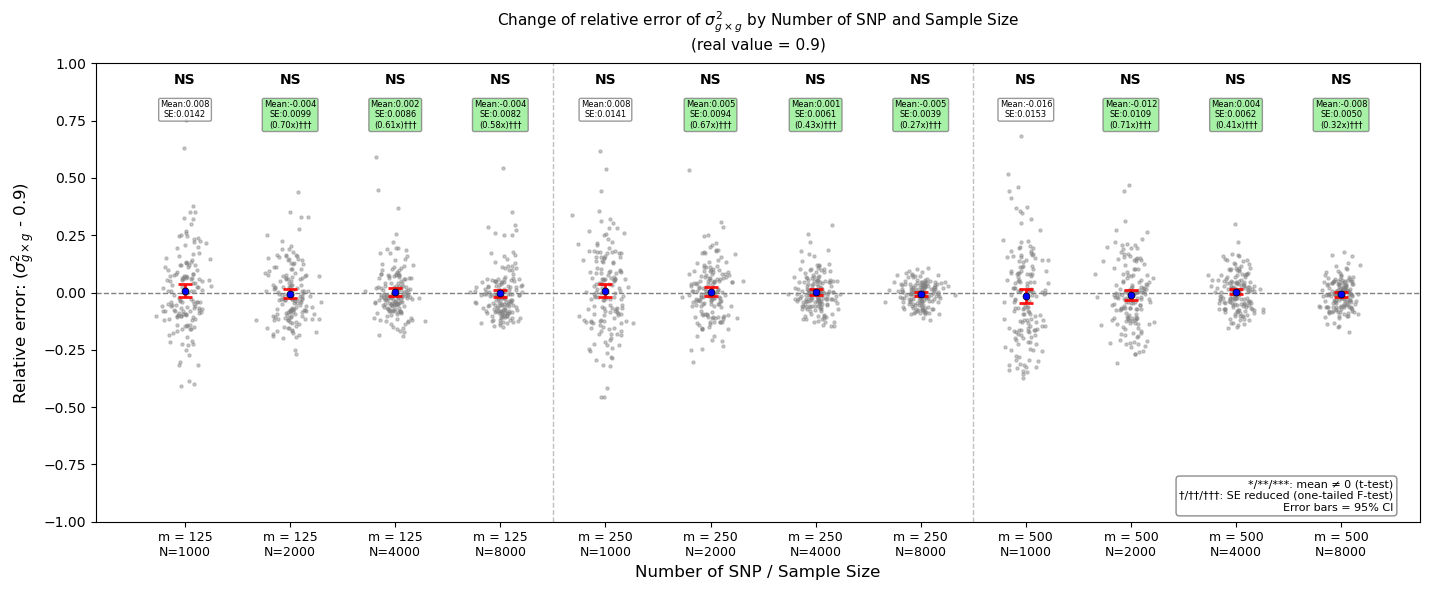

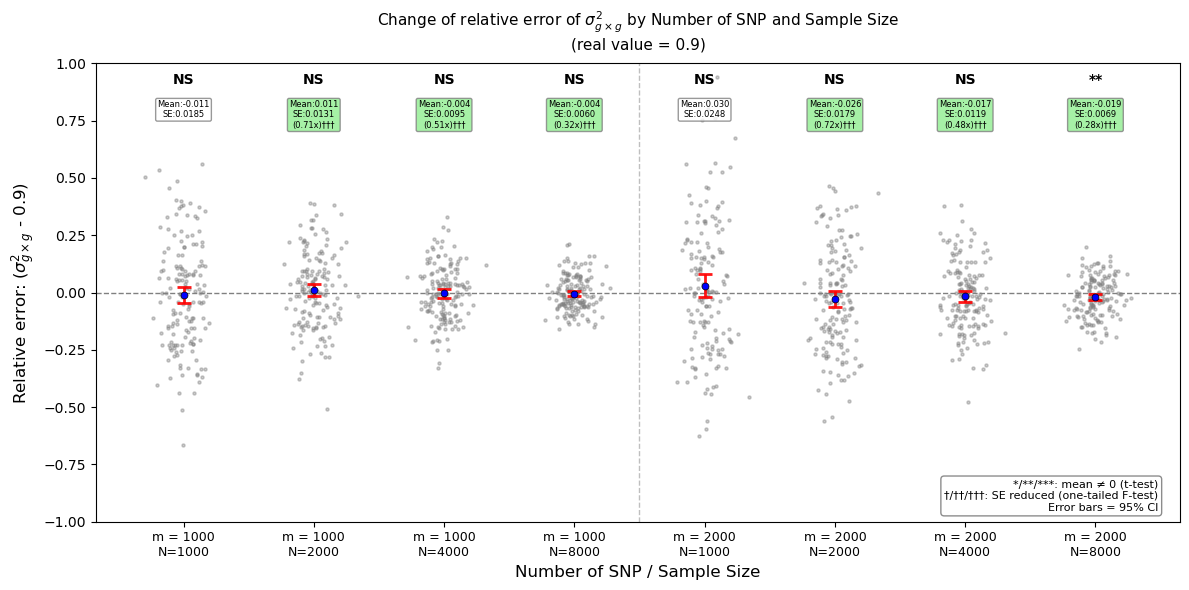

In [7]:
individual_sizes = [1000, 2000, 4000, 8000]
x_labels1 = ["m = 125", "m = 250","m = 500"]
x_labels2 = ["m = 1000","m = 2000"]

plot_relative_error_across_groups_combined(
    independent_m125,     
    independent_m250,  
    independent_m500,
    x_labels=x_labels1,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="Number of SNP"
)


plot_relative_error_across_groups_combined(
    independent_m1000,     
    independent_m2000,  
    x_labels=x_labels2,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="Number of SNP"
)

#### **Experiment 4.4**:
We then invetigate the influence of standardlization version of MOM.
**Hypothesis**: Standardlization will make the estimation unbiased.

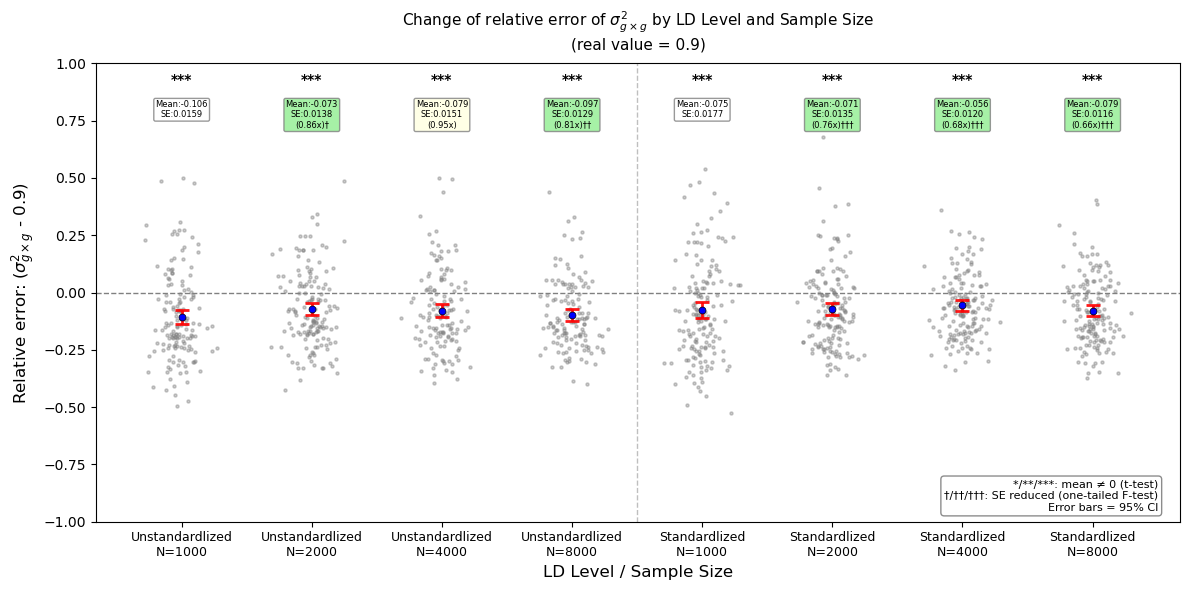

In [9]:
individual_sizes = [1000, 2000, 4000, 8000]
x_labels = ["Unstandardlized", "Standardlized"]
plot_relative_error_across_groups_combined(
    highLD_largeDataset_allVariants,
    highLD_largeDataset_allVariants_standard,
    x_labels=x_labels,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="LD Level"
)

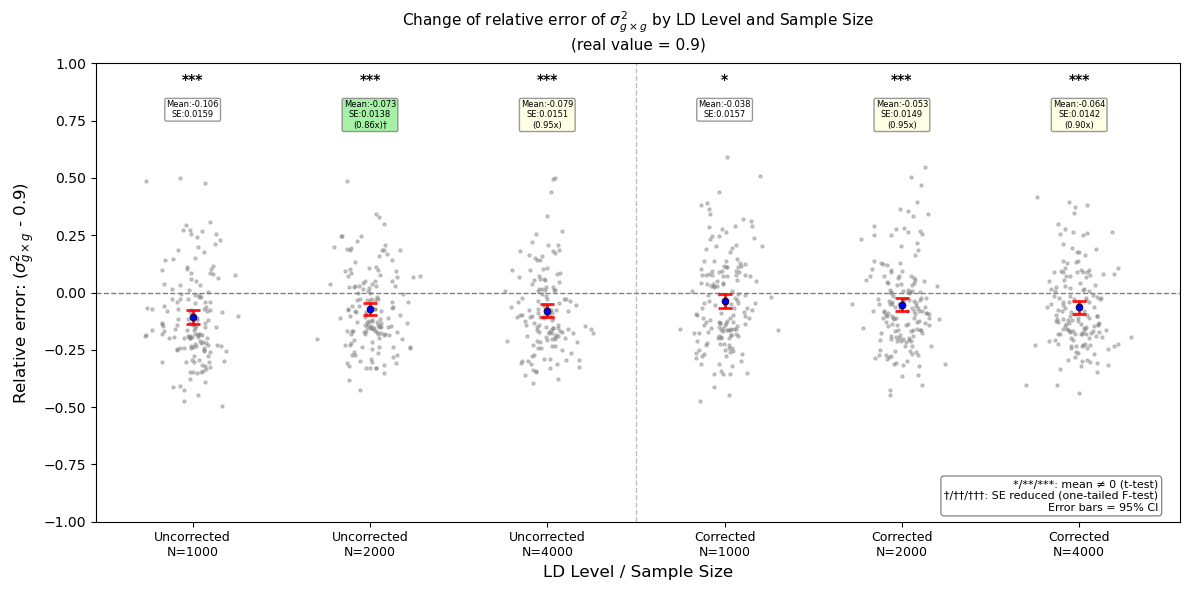

In [6]:
individual_sizes = [1000, 2000, 4000]
x_labels = ["Uncorrected", "Corrected"]
plot_relative_error_across_groups_combined(
    highLD_largeDataset_allVariants,
    highLD_largeDataset_allVariants_corrected,
    x_labels=x_labels,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="LD Level"
)